# 1. Import

In [1]:
%reload_ext autoreload
%autoreload 2

In [13]:
import sys
from pathlib import Path
sys.path.append(str(Path.home()) + '/rpi-canary-eval/modules')

from path import path_dict, col_seq_cc, col_seq_elx
import data_process, data_functions, dowhy_methods
import numpy as np
import pandas as pd
from datetime import datetime
from functools import reduce
from sklearn import preprocessing
from datetime import timedelta, datetime
import seaborn as sns
import warnings
from dowhy import CausalModel
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '%.3f' % x)

# 2. Load PMPM Data and Process


In [3]:
#### load pmpm data only
_, _, pmpm = data_process.load_data(path_dict)

### 2A. Take log of cost

In [4]:
pmpm.ALLOW_AMT = pmpm.ALLOW_AMT.apply(data_process.log_)
pmpm.ALLOW_IP = pmpm.ALLOW_IP.apply(data_process.log_)
pmpm.ALLOW_ER = pmpm.ALLOW_ER.apply(data_process.log_)

In [6]:
medicaid_mask = pmpm.MEDICAID_LOB.str.contains(r'.*Medicaid-.*')
pmpm['LOB'] = 1
pmpm.loc[medicaid_mask, 'LOB'] = 0
pmpm['MEDICAID_LOB'] = pmpm['LOB']
pmpm = pmpm.drop(['LOB'], axis=1)

In [8]:
pmpm.head()

PERS_ID     MYR  MEDICAID_LOB  AGE_AT_MIDMONTH  ALLOW_AMT  ALLOW_ER  \
0  2567954  201709             1               95      7.303     0.000   
1  2567954  201802             1               95      0.693     0.000   
2  2567954  201711             1               95      0.693     0.000   
3  2567954  201804             1               96      7.577     0.000   
4  2567954  201707             1               95      4.290     0.000   

   ALLOW_IP  CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  ...  CC_PTSD  \
0     0.000    0.000         0.000              0.000  ...    0.000   
1     0.000    0.000         0.000              0.000  ...    0.000   
2     0.000    0.000         0.000              0.000  ...    0.000   
3     0.000    0.000         0.000              0.000  ...    0.000   
4     0.000    0.000         0.000              0.000  ...    0.000   

   CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  \
0             0.000                   0.000           0.000            0.000   
1             0.000                   0.000           0.000            0.000   
2             0.000                   0.000           0.000            0.000   
3             0.000                   0.000           0.000            0.000   
4             0.000                   0.000           0.000            0.000   

   CC_STROKE  CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR  MBR_GNDR  
0      0.000       0.000               0.000             0.000         F  
1      0.000       0.000               0.000             0.000         F  
2      0.000       0.000               0.000             0.000         F  
3      0.000       0.000               0.000             0.000         F  
4      0.000       0.000               0.000             0.000         F  

[5 rows x 77 columns]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1893c35cc0>,
      dtype=object)

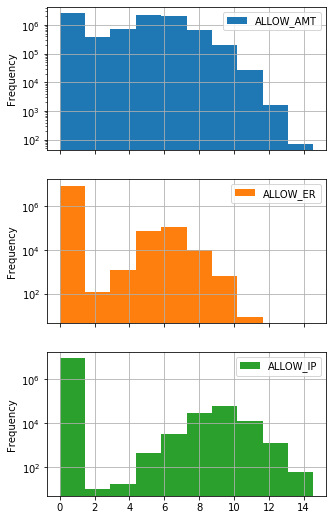

In [9]:
pmpm[["ALLOW_AMT", "ALLOW_ER", "ALLOW_IP"]].plot(kind="hist", figsize=(5,9), logy=True, grid=True, subplots=True)

# 3. Training the Deep Neural Network

In [28]:
import data_generator

### 3A. Create Training Feature
col_seq_CC is the sequence of columns when using CC set of features - found in path.py in /modules

In [29]:
train_X = data_generator.generate_data(pmpm, 201701,201712, features=True, col_seq=col_seq_cc)

### 3B. Create Training Labels

In [41]:
label_cols = ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'CC_DX_CNT', 'CC_DIABETES', 'CC_CHRONIC_KIDNEY', 'CC_HEART_FAILURE', 'CC_ISCHEMIC', 'CC_STROKE', 'CC_HYPERLIPIDEMIA', 'CC_HYPERTENSION']
metabolic_labels = ['CC_DIABETES', 'CC_CHRONIC_KIDNEY', 'CC_HEART_FAILURE', 'CC_ISCHEMIC', 'CC_STROKE', 'CC_HYPERLIPIDEMIA', 'CC_HYPERTENSION']
health_labels = ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'CC_DX_CNT']

In [31]:
train_Y = data_generator.generate_data(pmpm, 201901, 201901, features=False, label_cols=label_cols)

### 3C. Intersect two data sets

In [32]:
train_X, train_Y = data_generator.make_intersection(train_X, train_Y)

### 3D. Creating Test Feature

In [33]:
test_X = data_generator.generate_data(pmpm, 201801,201812, features=True, col_seq=col_seq_cc)

### 3E. Creating Test Labels

In [34]:
test_Y = data_generator.generate_data(pmpm, 202001, 202001, features=False, label_cols=label_cols)

### 3F. Intersect two data sets

In [35]:
test_X, test_Y = data_generator.make_intersection(test_X, test_Y)

In [36]:
train_X.shape, train_Y.shape, test_X.shape, test_Y.shape

### 3G. Define Model Architecture

In [47]:
import tensorflow as tf
from tensorflow import keras
from numpy import loadtxt
import tensorflow.keras.backend as K
import keras_model

In [38]:
baseline_model = keras_model.make_model_5(input_shape=train_X.shape[1], h_output_shape=3, m_output_shape=7)

In [39]:
baseline_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 75)           0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          9728        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128)          512         dense[0][0]                      
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128)          0           batch_normalization[0][0]        
__________________________________________________________________________________________________
dense_1 (D

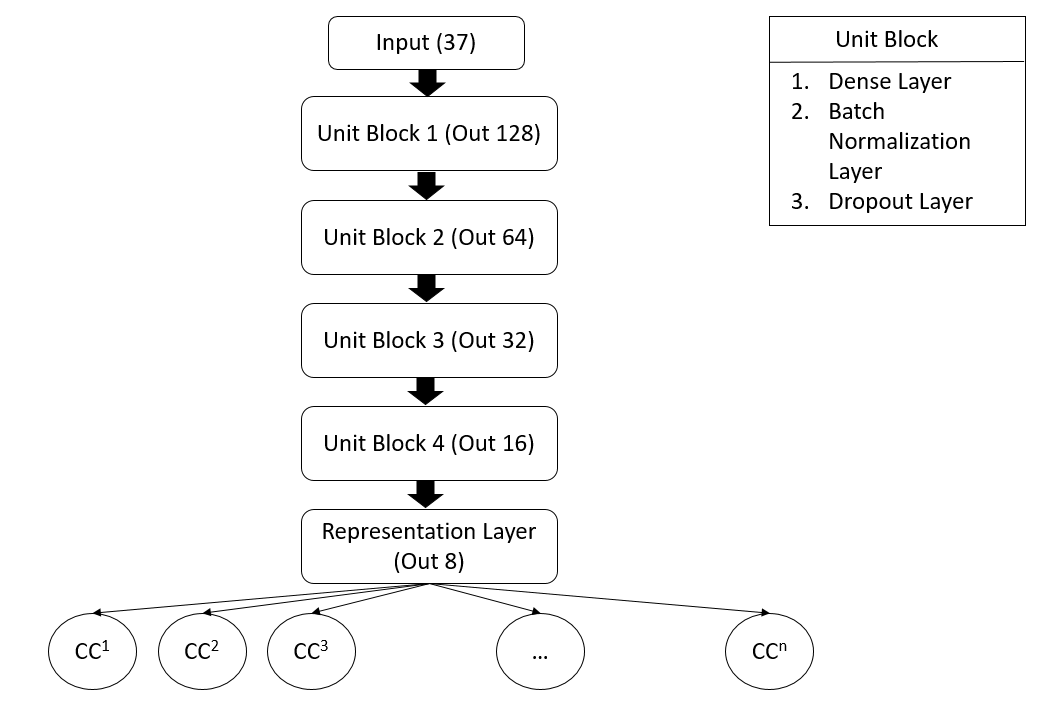

In [22]:
from IPython.display import Image
Image(filename='./images/model4.PNG', width=800, height=800)

### 3H. Model Fit

In [42]:
train_Y[health_labels]

AGE_AT_MIDMONTH  ALLOW_AMT  CC_DX_CNT
PERS_ID                                       
2562798              104      5.209          7
2563500              103      3.761          6
2563709              102      3.296          6
2563861              102      5.407         10
2563892              102      4.263          9
...                  ...        ...        ...
4401198               26      0.000          1
4401202               77      5.720          1
4401203               53      0.000          2
5000189               30      6.961          4
5052049               25      5.814          0

[125294 rows x 3 columns]

In [44]:
num_epochs = 20

#use this when multi-dim vectored output head
baseline_history = baseline_model.fit(train_X.values, [train_Y[health_labels].values, train_Y[metabolic_labels].values], epochs=num_epochs, validation_split=0.1, batch_size=128, verbose=1)

Train on 112764 samples, validate on 12530 samples
Epoch 1/20
112764/112764 [==============================] - 5s 44us/step - loss: 8.2082 - health_output_loss: 7.7998 - metabolic_output_loss: 0.4084 - health_output_mean_absolute_error: 7.7998 - metabolic_output_acc: 0.8061 - val_loss: 2.6770 - val_health_output_loss: 2.3764 - val_metabolic_output_loss: 0.3006 - val_health_output_mean_absolute_error: 2.3764 - val_metabolic_output_acc: 0.8684
Epoch 2/20
112764/112764 [==============================] - 4s 36us/step - loss: 4.4607 - health_output_loss: 4.1249 - metabolic_output_loss: 0.3357 - health_output_mean_absolute_error: 4.1249 - metabolic_output_acc: 0.8498 - val_loss: 2.7875 - val_health_output_loss: 2.4915 - val_metabolic_output_loss: 0.2960 - val_health_output_mean_absolute_error: 2.4915 - val_metabolic_output_acc: 0.8715
Epoch 3/20
112764/112764 [==============================] - 4s 35us/step - loss: 4.0133 - health_output_loss: 3.6844 - metabolic_output_loss: 0.3289 - health_o

In [45]:
baseline_history.history.keys()

dict_keys(['val_loss', 'val_health_output_loss', 'val_metabolic_output_loss', 'val_health_output_mean_absolute_error', 'val_metabolic_output_acc', 'loss', 'health_output_loss', 'metabolic_output_loss', 'health_output_mean_absolute_error', 'metabolic_output_acc'])

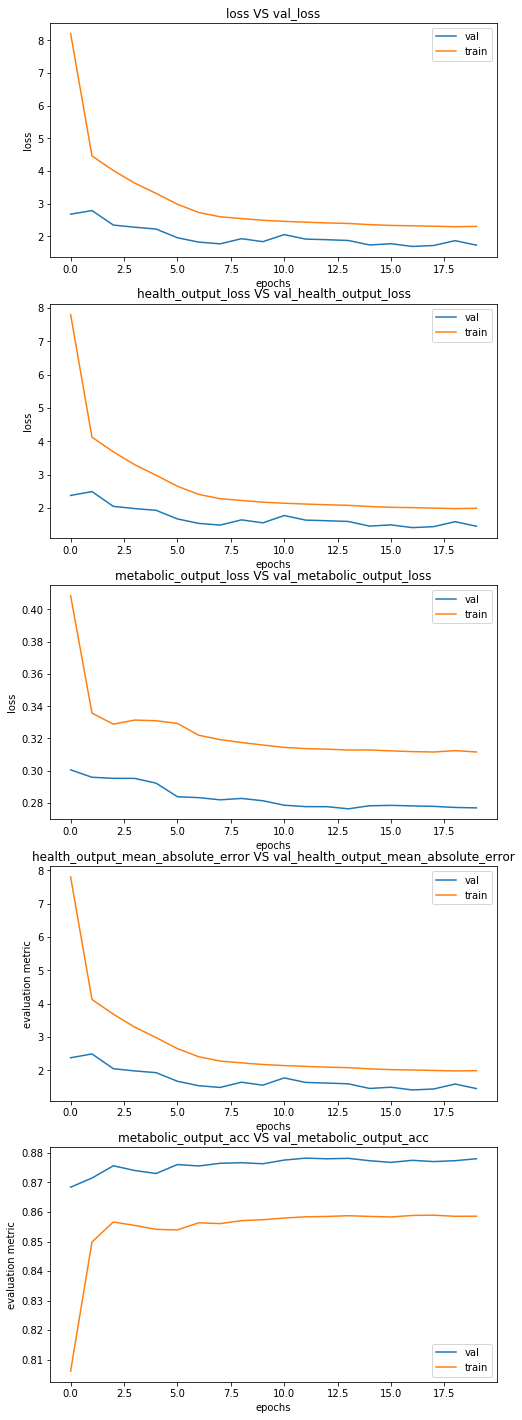

In [50]:
keras_model.plot_history(baseline_history, num_epochs, figsize=(8, 25))

In [53]:
print("Training Performance:",baseline_model.evaluate(train_X.values, [train_Y[health_labels].values, train_Y[metabolic_labels].values]))
print("Test Performance:",baseline_model.evaluate(test_X.values, [test_Y[health_labels].values, test_Y[metabolic_labels].values]))

125294/125294 [==============================] - 3s 23us/step
Training Performance: [1.7135958153702917, 1.4129749656871005, 0.3006208493723094, 1.4129749656871005, 0.8645528730722826]
137176/137176 [==============================] - 3s 23us/step
Test Performance: [1.7095542372701718, 1.4164561833585603, 0.29309805392334326, 1.4164561833585603, 0.8687869345904745]


### Evaluation for Multi-label classification

*Hamming-Loss: It is the fraction of labels that are incorrectly predicted, i.e., the fraction of the wrong labels to the total number of labels*

In [64]:
from sklearn.metrics import hamming_loss, accuracy_score 
hamming_loss(test_Y[metabolic_labels].values, np.round_(baseline_model.predict(test_X.values)[1]))

*Exact Match Ratio/ Subset Accuracy: It is the most strict metric, indicating the percentage of samples that have all their labels classified correctly*

In [65]:
accuracy_score(test_Y[metabolic_labels].values, np.round_(baseline_model.predict(test_X.values)[1]))

### 3I. Latent Model upto Representation Layer

In [66]:
latent_model = tf.keras.Model(baseline_model.input, baseline_model.get_layer("representation").output)

In [67]:
latent_model.predict(train_X).shape

In [68]:
#freeze all the layers in both models
for layer in baseline_model.layers:
    layer.trainable=False
for layer in latent_model.layers:
    layer.trainable=False

### 3J. Save the Model

In [69]:
## save the models
baseline_model.save('../temp/TF_Full_Model_m5')
latent_model.save('../temp/TF_Latent_Model_m5')

In [70]:
#save in S3
import boto3
s3 = boto3.client('s3')
bucket = 'cdphp-s3-us-e-p-pond'
s3.upload_file( str(Path.home()) + '/rpi-canary-eval/temp/TF_Latent_Model_m5',
                bucket, 
                'rpi/nneehal/MODELS/TF_Latent_Model_m5',
                ExtraArgs = {'ACL':"bucket-owner-full-control", 'ServerSideEncryption':'AES256'})
s3.upload_file( str(Path.home()) + '/rpi-canary-eval/temp/TF_Full_Model_m5',
                bucket, 
                'rpi/nneehal/MODELS/TF_Full_Model_m5',
                ExtraArgs = {'ACL':"bucket-owner-full-control", 'ServerSideEncryption':'AES256'})